# Notebook

## Load the sample data

In [5]:
import duckdb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette=sns.color_palette("colorblind"))


DB = "sampled-data/crossref.duckdb"
conn = duckdb.connect(DB)
conn.sql("show tables")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ members │
│ works   │
└─────────┘

In [10]:
w_refs_count = conn.table("works").filter("has_refs = True").count("*").fetchone()[0]
wo_refs_count = conn.table("works").filter("has_refs = False").count("*").fetchone()[0]
total_count = conn.table("works").count("*").fetchone()[0]
print(f"""
Sample size:
with references:\t{w_refs_count}
without references:\t{wo_refs_count}
total:\t\t\t{total_count}
""")


Sample size:
with references:	983738
without references:	994380
total:			1978118



## Explore characteristics of works sample

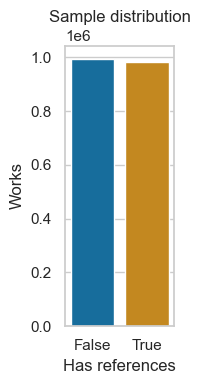

In [44]:
from matplotlib.ticker import ScalarFormatter


fig, (ax) = plt.subplots(1,1, figsize = (2,4))

rel = conn.table("works").aggregate("has_refs, count(*) as count")

sns.barplot(
    ax=ax,
    data=rel.df(),
    x="has_refs",
    hue="has_refs",
    y='count',
    orient="x"
).set_title("Sample distribution")
ax.set_xlabel("Has references")
ax.set_ylabel("Works")
plt.legend([],[], frameon=False)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.ticklabel_format(style='sci', axis='y')

plt.tight_layout()
fig.savefig("vis/sample_has_refs_distribution.png")

In [11]:
type_proportion_sql = """
WITH work_count AS (SELECT work_type, count(*) AS type_count FROM works GROUP BY work_type)

SELECT w.work_type, has_refs as "has references", count(*)/wc.type_count proportion
FROM works w
LEFT JOIN work_count wc ON w.work_type = wc.work_type
GROUP BY (w.work_type, w.has_refs, wc.type_count)
HAVING type_count IS NOT NULL
ORDER BY wc.type_count desc
"""

conn.sql(type_proportion_sql).limit(4)

┌─────────────────┬────────────────┬────────────────────┐
│    work_type    │ has references │     proportion     │
│     varchar     │    boolean     │       double       │
├─────────────────┼────────────────┼────────────────────┤
│ journal-article │ true           │ 0.5839864974730586 │
│ journal-article │ false          │ 0.4160135025269414 │
│ book-chapter    │ true           │ 0.3714946935876236 │
│ book-chapter    │ false          │ 0.6285053064123765 │
└─────────────────┴────────────────┴────────────────────┘

In [13]:
import numpy as np


percentage_labels = [float(round(i,1)) for i in np.linspace(0,1,11)]
percentage_labels

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

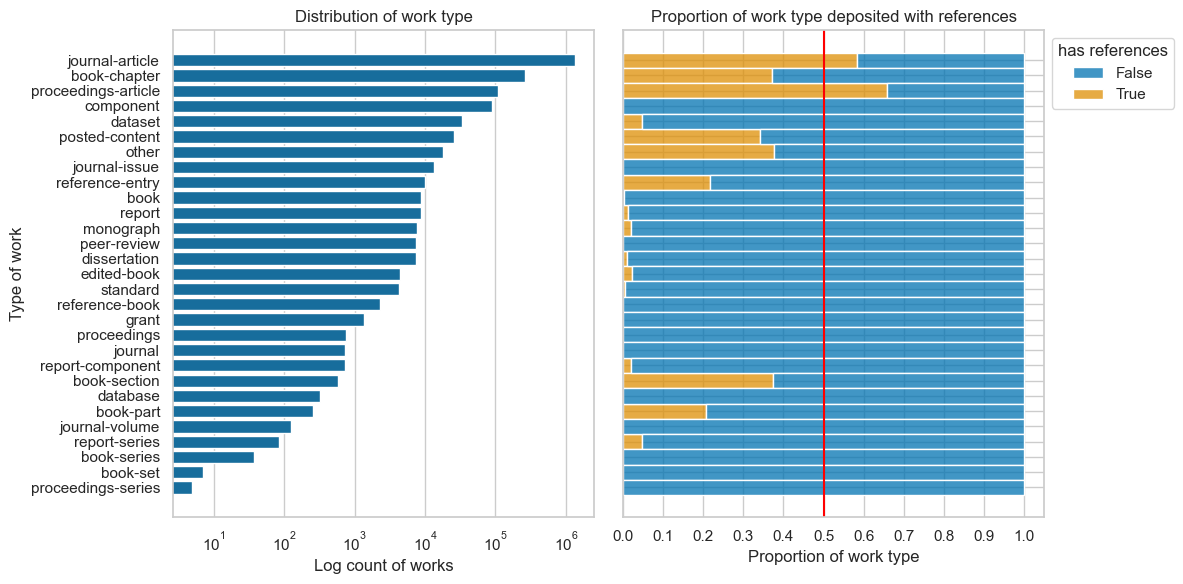

In [35]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (12,6), sharey=True)

df = conn.table("works").aggregate("work_type, count(*) as count").order("count desc").df()
sns.barplot(
    ax=ax1,
    data=df,
    y="work_type",
    x="count",
).set_title("Distribution of work type")
ax1.set_ylabel("Type of work")
ax1.set_xlabel("Log count of works")
ax1.set_xscale("log")

df = conn.sql(type_proportion_sql).df()
sns.histplot(
    ax=ax2,
    data=df,
    y="work_type",
    hue="has references",
    weights='proportion',
    multiple="stack"
).set_title("Proportion of work type deposited with references")
ax2.set_ylabel("Type of work")
ax2.set_xlabel("Proportion of work type")
ax2.set_xticks(np.linspace(0,1,11), labels=percentage_labels)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.axvline(0.5, 0, 1, color='r')

# plt.suptitle("Distribution of sample\nn = 1 978 118")

plt.tight_layout()
fig.savefig("vis/sample_work_type_distribution.png")

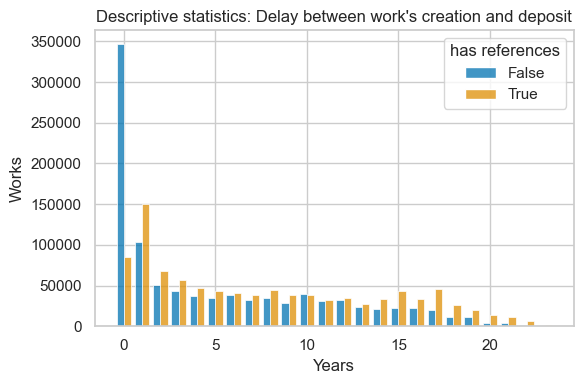

In [43]:
fig, (ax) = plt.subplots(1,1, figsize = (6,4), sharex=True, sharey="row")

df = conn.table("works").select('has_refs as "has references", ceil(deposit_delay_days/365) as delay').df()

sns.histplot(
    ax=ax,
    data=df, 
    x="delay",
    discrete=True,
    hue="has references",
    shrink=.8,
    multiple="dodge"
).set_title("Descriptive statistics: Delay between work's creation and deposit")
ax.set_xlabel("Years")
ax.set_ylabel("Works")

plt.tight_layout()
fig.savefig("vis/sample_deposit_delay_per_has_refs.png")

In [39]:
conn.table("works").select('has_refs, ceil(deposit_delay_days/365) as delay').aggregate('has_refs, count(*)')

┌──────────┬──────────────┐
│ has_refs │ count_star() │
│ boolean  │    int64     │
├──────────┼──────────────┤
│ true     │       983738 │
│ false    │       994380 │
└──────────┴──────────────┘

In [68]:
from scipy import stats

rel = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as has_refs,
    citations_incoming
from works
""")

bools = rel.select("has_refs").fetchnumpy()
bools = np.array(bools['has_refs'])

conts = rel.select("citations_incoming").fetchnumpy()
conts = np.array(conts['citations_incoming'])

# arg1 = array_like of bools
# arg2 = array_like

prb = stats.pointbiserialr(bools, conts)

print(f"""
Point-biserial correlation
Significance result: {prb.statistic}
P-value: {prb.pvalue}
""")
prb


Point-biserial correlation
Significance result: 0.0962778895057796
P-value: 0.0



SignificanceResult(statistic=np.float64(0.0962778895057796), pvalue=np.float64(0.0))

In [108]:
from scipy import stats

rel = conn.sql("""
select 
    citations_incoming,
    citations_outgoing
from works
where has_refs = True
""")

x = rel.select("citations_outgoing").fetchnumpy()
x = np.array(x['citations_outgoing'])

y = rel.select("citations_incoming").fetchnumpy()
y = np.array(y['citations_incoming'])

spr = stats.spearmanr(y, x)

pr = stats.pearsonr(y,x)

print(f"""
Spearman correlation coefficient
Significance result: {spr.statistic}
P-value: {spr.pvalue}

Pearson correlation coefficient
Significance result: {pr.statistic}
P-value: {pr.pvalue}
""")



Spearman correlation coefficient
Significance result: 0.3530306654203059
P-value: 0.0

Pearson correlation coefficient
Significance result: 0.06389336083102433
P-value: 0.0



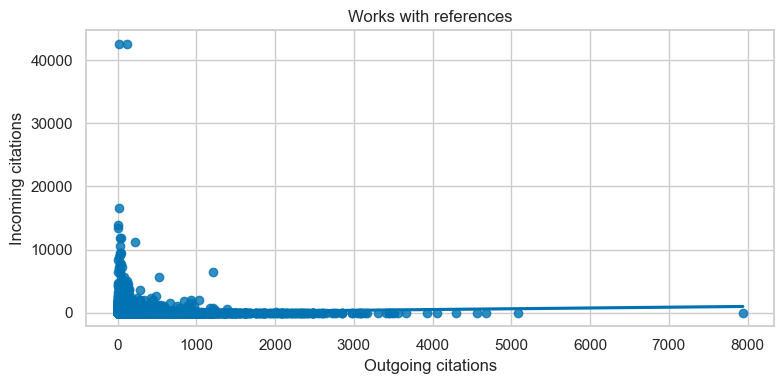

In [107]:
fig, ((ax1)) = plt.subplots(1,1, figsize = (8,4))

df = conn.sql("""
select 
    citations_incoming,
    citations_outgoing
from works
where has_refs = True
""").df()
sns.regplot(
    df, 
    x="citations_outgoing", 
    y="citations_incoming", 
    ax=ax1
).set_title("Works with references")
ax1.set_xlabel("Outgoing citations")
ax1.set_ylabel("Incoming citations")

# df = conn.sql("""
# select 
#     citations_incoming,
#     citations_outgoing
# from works
# where has_refs = True
# and citations_incoming < 5_000
# and citations_outgoing < 5_000
# """).df()
# sns.regplot(
#     df, 
#     x="citations_outgoing", 
#     y="citations_incoming", 
#     ax=ax2
# ).set_title("Excluding outliers, citations < 5000")
# ax2.set_xlabel("Outgoing citations")
# ax2.set_ylabel("Incoming citations")

plt.tight_layout()
fig.savefig("vis/linear_regression.png")